In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from Color import *

# Matplotlib font configuration
from MatplotlibFonts import *

# Change the font size
rcParams.update({"font.size": 15})

In [4]:
RESULT_DIR='../benchmarks/results'

In [5]:
# Benchmarks in order
Benchmarks = [
    'coremark',
    'sha',
    'crc',
    'aes',
    'dijkstra',
    'picojpeg'
]

# Configurations in order
Configurations = [
    'opt-ratchet',
    'opt-baseline',
    'opt-writebuf',
    'opt-loop',
    'opt-reducedpop',
    'opt-all'
]
from BenchmarkConfiguration import *

In [6]:
# Load the benchmarks
def load_benchmark(bench):
    file = RESULT_DIR + '/raw/' + bench + '-results-table-raw.csv'
    return pd.read_csv(file).set_index('Configuration')

df = {}
for bench in Benchmarks:
    df[bench] = load_benchmark(bench)

In [7]:
# Order per group: Ratchet, Ratchet+Noelle, Write Buffering, Loop Clustering, Opt-all
group_size = len(Configurations)
group_count = len(Benchmarks)
print('Group count:', group_count)
print('Group size:', group_size)

Group count: 6
Group size: 6


In [8]:
df['sha'] = df['sha'].reindex(ConfigurationNameMap)
df['sha']

,Cycles,Checkpoints,IR-checkpoints,Call-checkpoints,Pop-checkpoints,Spill-checkpoints,Execution,Execution-baseline,Overhead-baseline-%,Overhead-ratchet-%
Configuration,,,,,,,,,,
opt-ratchet,51115435,599751,589621,138,9986.0,5,3.564081,2.341341,390.98,0.00
opt-baseline,21831688,131991,121861,138,9986.0,5,1.522239,1.000000,0.00,-79.63
opt-writebuf,21787919,131991,121861,138,9986.0,5,1.519187,0.997995,-0.58,-79.75
opt-loop,19122806,78467,53643,9921,10025.0,4877,1.333359,0.875920,-36.17,-87.00
opt-reducedpop,21493564,127017,121861,138,5012.0,5,1.498663,0.984512,-4.51,-80.55
opt-all,18448499,68621,53643,5049,5051.0,4877,1.286342,0.845033,-45.17,-88.83


In [9]:
dfa = pd.DataFrame()
for bench in Benchmarks:
    dfa[bench] = df[bench].reindex(ConfigurationNameMap)['Execution']
    
dfa.rename(index=ConfigurationNameMap, inplace=True)
dfa

,coremark,sha,crc,aes,dijkstra,picojpeg
Configuration,,,,,,
Ratchet,3.396362,3.564081,3.744782,4.413004,1.072804,5.524218
Improved Ratchet,3.236080,1.522239,3.744782,2.948137,1.026569,5.421913
Write Clustering,3.248653,1.519187,3.748431,2.700178,1.025449,4.614697
Loop Clustering,2.575403,1.333359,3.744685,2.100523,1.025710,5.222782
Epilog Clustering,3.170887,1.498663,2.841596,2.804732,1.021676,4.383836
Complete System,2.522491,1.286342,2.841985,1.721306,1.046363,4.023521


In [10]:
mean_ratchet = dfa.T[ConfigurationNameMap['opt-ratchet']].mean()
mean_baseline = dfa.T[ConfigurationNameMap['opt-baseline']].mean()
mean_opt_all = dfa.T[ConfigurationNameMap['opt-all']].mean()

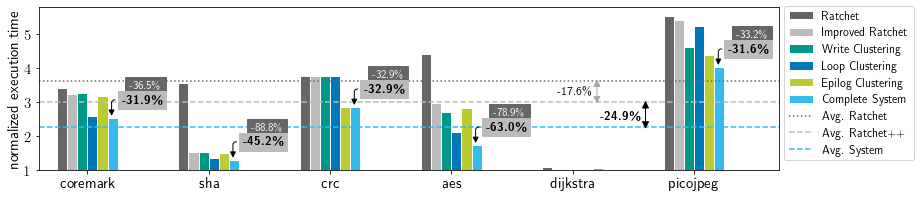

In [18]:
bars = dfa.T.plot(kind='bar', ylim=(1,None), figsize=(13,3), color=[ConfigurationColorMap[c] for c in Configurations], edgecolor='white', linewidth=1)
plt.xticks(rotation=0)

handles, labels = bars.get_legend_handles_labels()

# Average for Ratchet and Opt-All
mean_ratchet_line = plt.axhline(y = mean_ratchet, color = ConfigurationColorMap['opt-ratchet'], 
                                linestyle = ':', label='Avg. Ratchet')
mean_baseline_line = plt.axhline(y = mean_baseline, color = ConfigurationColorMap['opt-baseline'],
                                 linestyle = '--', label='Avg. Ratchet++')
mean_opt_all_line = plt.axhline(y = mean_opt_all, color = ConfigurationColorMap['opt-all'],
                                linestyle = '--',label='Avg. System')

# Manually place the average lines at the end of the legend
handles.extend([mean_ratchet_line, mean_baseline_line, mean_opt_all_line])
#bars.legend(handles=handles, bbox_to_anchor=(0, 1.0, 1, 0), loc="lower left", mode='expand', ncol=4)
bars.legend(handles=handles, bbox_to_anchor=(0, 1.04, 1.19, 0), loc="upper right", fancybox=True, ncol=1, fontsize=12)

# Iterate through the benchmarks (in order)
for idx, bench in enumerate(Benchmarks):
    # Skip some benchmark(s)
    skip = ['dijkstra']
    if bench in skip:
        continue
        
    overhead_ratchet_perc = df[bench]['Overhead-ratchet-%']['opt-all']
    overhead_baseline_perc = df[bench]['Overhead-baseline-%']['opt-all']
    execution_value = df[bench]['Execution']['opt-all']
    
    def add_bar_label(text, text_loc, textcolor='black', facecolor='white', edgecolor='black', fontsize=11, draw_arrow=False):
        if draw_arrow == True:
            arrowprops = dict(arrowstyle='-|>', fc='black', connectionstyle='angle,angleA=0,angleB=90,rad=3')
        else:
            arrowprops = None
        
        plt.annotate(text, xy=(idx+0.2, execution_value), xytext=text_loc,
            color=textcolor,
            xycoords=('data'), textcoords='offset points', fontsize=fontsize,
            horizontalalignment='right', verticalalignment='center',
            bbox=dict(facecolor=facecolor, linewidth='1', edgecolor=edgecolor),
            arrowprops=arrowprops,
        )
        
    add_bar_label('{:02.1f}\%'.format(overhead_ratchet_perc),
                  text_loc=(50,32),
                  fontsize=11,
                  textcolor='white',
                  edgecolor=ConfigurationColorMap['opt-ratchet'],
                  facecolor=ConfigurationColorMap['opt-ratchet'],
                  draw_arrow=False)
    add_bar_label('\\textbf{'+'{:02.1f}\%'.format(overhead_baseline_perc)+'}',
                  text_loc=(50, 18),
                  fontsize=12,
                  edgecolor=ConfigurationColorMap['opt-baseline'],
                  facecolor=ConfigurationColorMap['opt-baseline'],
                  draw_arrow=True)
    

# Annotate the average lines
plt.annotate('', xy=(4.6, mean_opt_all-0.1), xytext=(4.6,mean_baseline+0.1),
             arrowprops=dict(arrowstyle='<|-|>', fc='black'))
reduction_perc = (mean_baseline-mean_opt_all)/mean_baseline * 100
plt.annotate('\\textbf{'+'-{:02.1f}\%'.format(reduction_perc)+'}', xy=(4.6, mean_opt_all+(mean_baseline-mean_opt_all)/2), 
             xytext=(-5,-2), textcoords='offset points',
             fontsize=12,
             horizontalalignment='right', verticalalignment='center')


plt.annotate('', xy=(4.2, mean_baseline-0.1), xytext=(4.2,mean_ratchet+0.1),
             arrowprops=dict(arrowstyle='<|-|>', fc='darkgrey', edgecolor='darkgrey'))
reduction_perc = (mean_ratchet-mean_baseline)/mean_ratchet * 100
plt.annotate('-{:02.1f}\%'.format(reduction_perc), xy=(4.2, mean_baseline+(mean_ratchet-mean_baseline)/2), 
             xytext=(-5,0), textcoords='offset points',
             fontsize=12,
             horizontalalignment='right', verticalalignment='center')

#plt.subplots_adjust(right=1.3)
plt.xlim(-0.4, len(Benchmarks)-1+0.7)

# Set the axis
#plt.xlabel('benchmark')
plt.ylabel('normalized execution time')

# Show the plot
plt.tight_layout()
plt.show()


In [19]:
# Save the figure
fig = bars.get_figure()
fig.savefig('plots/benchmark-comparison.pdf')

In [12]:


# Create the checkpoint figure



In [13]:
for bench in Benchmarks:
    #cps = df[bench]['Checkpoints']['opt-baseline']-1
    dfb = df[bench]
    cps = (dfb['IR-checkpoints']+dfb['Call-checkpoints']+dfb['Pop-checkpoints']+dfb['Spill-checkpoints'])['opt-baseline']
    dfb['IR-checkpoints-%'] =  dfb['IR-checkpoints']/cps*100
    dfb['Call-checkpoints-%'] =  dfb['Call-checkpoints']/cps*100
    dfb['Pop-checkpoints-%'] =  dfb['Pop-checkpoints']/cps*100
    dfb['Spill-checkpoints-%'] =  dfb['Spill-checkpoints']/cps*100

df['coremark']

,Cycles,Checkpoints,IR-checkpoints,Call-checkpoints,Pop-checkpoints,Spill-checkpoints,Execution,Execution-baseline,Overhead-baseline-%,Overhead-ratchet-%,IR-checkpoints-%,Call-checkpoints-%,Pop-checkpoints-%,Spill-checkpoints-%
Configuration,,,,,,,,,,,,,,
uninstrumented,2442326,0,0,0,7805.0,0,1.000000,0.309016,-100.00,-100.00,0.000000,0.000000,9.157896,0.000000
opt-ratchet,8295023,91317,68941,7230,10184.0,4961,3.396362,1.049530,7.17,0.00,80.891032,8.483227,11.949265,5.820925
opt-baseline,7903563,85228,62292,7230,10184.0,5521,3.236080,1.000000,0.00,-6.69,73.089514,8.483227,11.949265,6.477994
opt-writebuf,7934269,85765,62292,7232,10184.0,6056,3.248653,1.003885,0.56,-6.16,73.089514,8.485574,11.949265,7.105729
opt-loop,6289973,59713,35772,7230,10184.0,6526,2.575403,0.795840,-29.55,-34.26,41.972614,8.483227,11.949265,7.657198
opt-all,6160746,57884,35772,7230,7805.0,7076,2.522491,0.779490,-31.91,-36.47,41.972614,8.483227,9.157896,8.302533
loop-unroll-2,7042050,71919,46992,7232,20368.0,7510,2.883337,0.890997,-15.78,-21.41,55.137456,8.485574,23.898530,8.811762
loop-unroll-6,6447737,62066,36792,7234,20368.0,7855,2.639999,0.815801,-26.66,-31.56,43.169418,8.487920,23.898530,9.216563
loop-unroll-35,7287149,73719,32712,7232,20368.0,23590,2.983692,0.922008,-11.29,-17.22,38.382203,8.485574,23.898530,27.679022


In [14]:
dfc = {}
plot = ['IR-checkpoints-%', 'Spill-checkpoints-%', 'Call-checkpoints-%', 'Pop-checkpoints-%']

for p in plot:
    dfc[p] = pd.DataFrame()
    for bench in Benchmarks:
        dfc[p][bench] = df[bench].reindex(Configurations)[p]
    
    dfc[p].rename(index=ConfigurationNameMap, inplace=True)
    dfc[p].drop('Ratchet', inplace=True)
    

dfc[plot[1]]

,coremark,sha,crc,aes,dijkstra,picojpeg
Configuration,,,,,,
Improved Ratchet,6.477994,0.003788,0.725514,9.848343,17.533908,0.082701
Write Clustering,7.105729,0.003788,0.725514,4.980341,17.533908,0.193148
Loop Clustering,7.657198,3.694977,0.725514,15.989515,17.533908,0.440606
Epilog Clustering,6.477994,0.003788,0.725514,9.848343,17.533908,0.082701
Complete System,8.302533,3.694977,0.725514,12.338513,17.533908,0.633647


In [15]:
df['sha']

,Cycles,Checkpoints,IR-checkpoints,Call-checkpoints,Pop-checkpoints,Spill-checkpoints,Execution,Execution-baseline,Overhead-baseline-%,Overhead-ratchet-%,IR-checkpoints-%,Call-checkpoints-%,Pop-checkpoints-%,Spill-checkpoints-%
Configuration,,,,,,,,,,,,,,
opt-ratchet,51115435,599751,589621,138,9986.0,5,3.564081,2.341341,390.98,0.00,446.716418,0.104553,7.565725,0.003788
opt-baseline,21831688,131991,121861,138,9986.0,5,1.522239,1.000000,0.00,-79.63,92.325934,0.104553,7.565725,0.003788
opt-writebuf,21787919,131991,121861,138,9986.0,5,1.519187,0.997995,-0.58,-79.75,92.325934,0.104553,7.565725,0.003788
opt-loop,19122806,78467,53643,9921,10025.0,4877,1.333359,0.875920,-36.17,-87.00,40.641715,7.516479,7.595272,3.694977
opt-reducedpop,21493564,127017,121861,138,5012.0,5,1.498663,0.984512,-4.51,-80.55,92.325934,0.104553,3.797257,0.003788
opt-all,18448499,68621,53643,5049,5051.0,4877,1.286342,0.845033,-45.17,-88.83,40.641715,3.825290,3.826805,3.694977


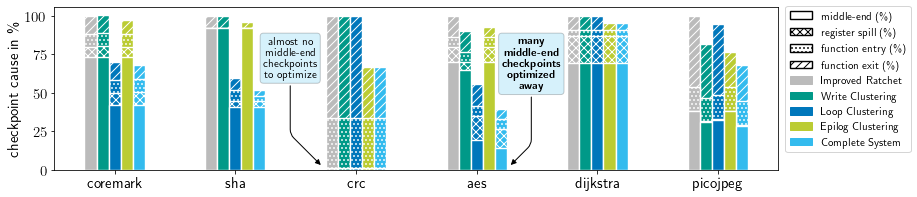

In [16]:
from matplotlib.patches import Patch

ax = plt.figure(figsize=(13,3)).add_subplot(111)

cc = [ConfigurationColorMap[c] for c in Configurations[1:]]
labels = [ConfigurationNameMap[c] for c in Configurations[1:]]
width = 0.5
lw = 1.4

def patchwork(ax, hatch):
    for bar in ax.patches:
        if bar.get_hatch() == None: 
            bar.set_hatch(hatch)
            
def plot_bar(N):
    D = dfc[plot[0]]
    for n in range(1, N+1):
        D = D + dfc[plot[n]]
        
    D.T.plot(kind='bar', ax=ax, color=cc, width=width, edgecolor='white', legend=None, linewidth=lw)
    patchwork(ax, hatch_map[plot[N]])

hatch_map = {
    'IR-checkpoints-%': '',
    'Spill-checkpoints-%': 'xxx',
    'Call-checkpoints-%': '...',
    'Pop-checkpoints-%': '///'
}

# Plot the overlapping bars
plot_bar(3)
plot_bar(2)
plot_bar(1)
plot_bar(0)

# Plot the description of the crc benchmark
props = dict(boxstyle='round', facecolor=Color['cyan'], alpha=0.2)
text =  'almost no\nmiddle-end\ncheckpoints\nto optimize'
plt.annotate(text, xy=(1.72, 2), xytext=(-32, 130),
        transform=ax.transAxes, textcoords='offset points', fontsize=11,
        horizontalalignment='center', verticalalignment='top',
        bbox=props,
        arrowprops=dict(arrowstyle='-|>', fc='black', connectionstyle='angle,angleA=90,angleB=-45,rad=5'),
)
props = dict(boxstyle='round', facecolor=Color['cyan'], alpha=0.2)
text =  '\\textbf{many}\n\\textbf{middle-end}\n\\textbf{checkpoints}\n\\textbf{optimized}\n\\textbf{away}'
plt.annotate(text, xy=(3.27, 2), xytext=(22, 130),
        transform=ax.transAxes, textcoords='offset points', fontsize=11,
        horizontalalignment='center', verticalalignment='top',
        bbox=props,
        arrowprops=dict(arrowstyle='-|>', fc='black', connectionstyle='angle,angleA=90,angleB=45,rad=5'),
)

plt.xticks(rotation=0)

handles = []
handles.append(Patch(label='middle-end (\%)', hatch=hatch_map['IR-checkpoints-%'],
                     facecolor='none', edgecolor='black', linewidth=lw))
handles.append(Patch(label='register spill (\%)', hatch=hatch_map['Spill-checkpoints-%'],
                     facecolor='none', edgecolor='black', linewidth=lw))
handles.append(Patch(label='function entry (\%)', hatch=hatch_map['Call-checkpoints-%'],
                     facecolor='none', edgecolor='black', linewidth=lw))
handles.append(Patch(label='function exit (\%)', hatch=hatch_map['Pop-checkpoints-%'],
                     facecolor='none', edgecolor='black', linewidth=lw))

for idx, l in enumerate(labels):
    handles.append(Patch(label=l, color=cc[idx]))

#ax.legend(handles=handles, bbox_to_anchor=(0, 1.0, 1, 0), loc="lower left", mode='expand', ncol=4)
ax.legend(handles=handles, bbox_to_anchor=(0, 1.04, 1.19, 0), loc="upper right", ncol=1, fontsize=11)

#plt.xlabel('benchmark')
plt.ylabel(r'checkpoint cause in \%')

plt.tight_layout()
plt.show()

In [17]:
# Save the figure
fig = ax.get_figure()
fig.savefig('plots/benchmark-checkpoint-distribution.pdf')